## XGBoost Model Aquifer Doganella

In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def plot_actual_vs_predicted() -> None:
    i = 0
    for column in y_test.columns:
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(y_test[f'{column}'].values, label=f'Actual {column}')
        plt.plot(y_pred[:, i] if len(y_pred.shape) == 2 else y_pred, label=f'Predicted {column}', linestyle='--')
        plt.legend()
        plt.title(f'Actual vs Predicted - {column}')
        plt.show()
        i+=1

In [2]:
df = pd.read_csv('../../data/clean/Aquifer_Doganella.csv', index_col='Date', parse_dates=True)
print(df.tail())

            Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
Date                                                                     
26/06/2020                        -50.32                       -100.35   
27/06/2020                        -50.32                       -100.56   
28/06/2020                        -50.32                       -100.56   
29/06/2020                        -50.32                       -100.56   
30/06/2020                        -50.78                       -100.56   

            Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
Date                                                                     
26/06/2020                      -100.880                       -101.49   
27/06/2020                      -100.840                       -101.59   
28/06/2020                      -100.920                       -101.59   
29/06/2020                      -101.190                       -101.59   
30/06/2020                      -101.

In [3]:
# Creating lag features for the model (for each feature)
def create_lagged_features(data, lag=1):
    df_lagged = data.copy()
    for col in data.columns:
        for i in range(1, lag+1):
            df_lagged[f'{col}_lag{i}'] = df_lagged[col].shift(i)
    return df_lagged.dropna()

# Set the lag (how many past time steps to use)
lag_steps = 5
lagged_data = create_lagged_features(df, lag=lag_steps)

# Input (X) and target (y) data
X = lagged_data.drop(df.columns, axis=1)  # Drop the current values, use lagged features
y = lagged_data[df.columns]  # Predict future values for each feature

# Split into train and test sets (keeping the time series order intact)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

XGBoost model

In [4]:
xgb_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [5]:
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred

array([[ -45.960335, -100.17286 , -114.54489 , -102.0865  , -104.39496 ,
         -98.60055 ,  -95.79071 ,  -97.0005  ,  -90.468864],
       [ -46.037827, -100.20489 , -114.547066, -102.06356 , -104.39159 ,
         -98.60435 ,  -95.78973 ,  -97.0006  ,  -90.4689  ],
       [ -46.103348, -100.20128 , -114.45566 , -102.06356 , -104.389435,
         -98.60435 ,  -95.794395,  -97.00012 ,  -90.46593 ],
       [ -46.582115, -100.31424 , -114.458015, -102.05584 , -104.38899 ,
         -98.50797 ,  -95.79587 ,  -96.998764,  -90.63965 ],
       [ -46.604225, -100.31409 , -114.46432 , -102.05584 , -104.38954 ,
         -98.344284,  -95.793495,  -97.00969 ,  -90.65662 ],
       [ -46.50602 , -100.53451 , -114.4367  , -102.05584 , -104.39132 ,
         -98.334305,  -95.79452 ,  -97.00975 ,  -90.64697 ],
       [ -49.14805 , -100.53451 , -114.429855, -102.05518 , -104.384544,
         -98.334305,  -95.82242 ,  -96.92765 ,  -90.6756  ],
       [ -49.238792, -100.51878 , -114.4286  , -102.05426 , -1

In [6]:
# Evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.575779044564246


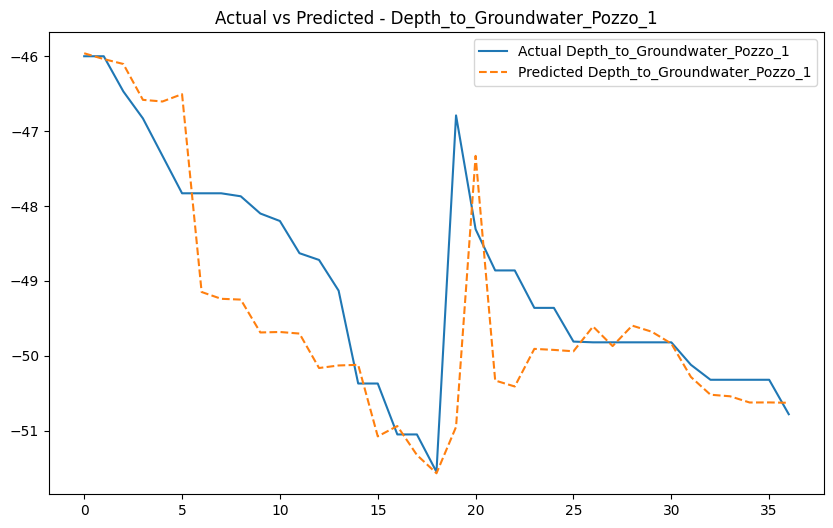

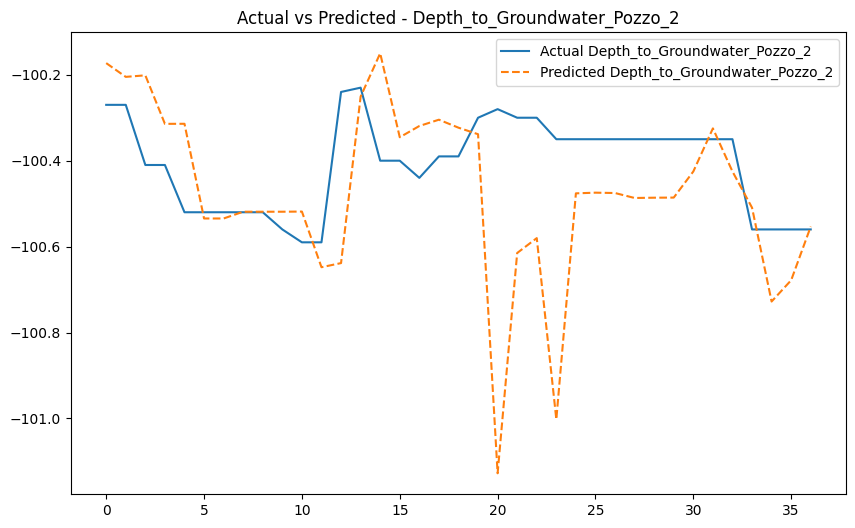

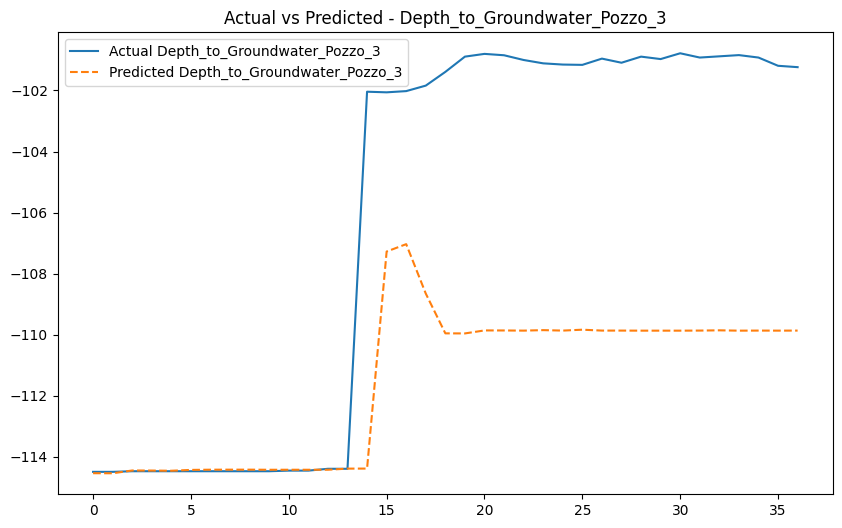

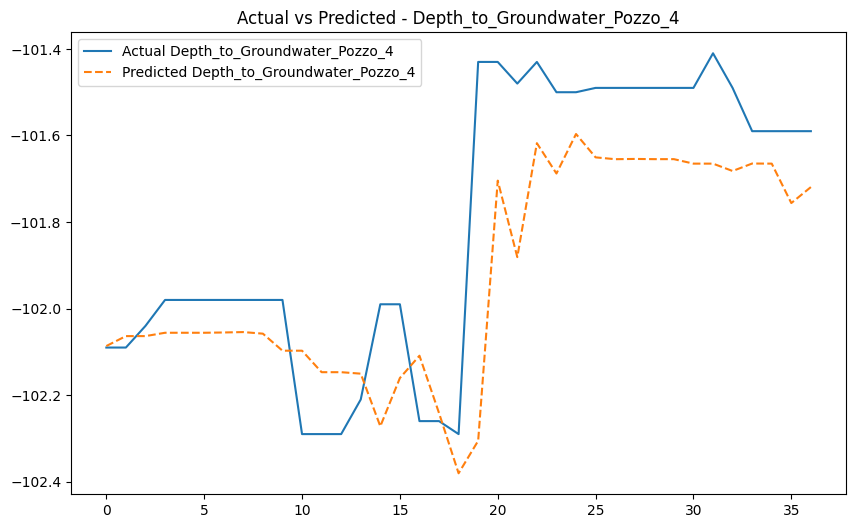

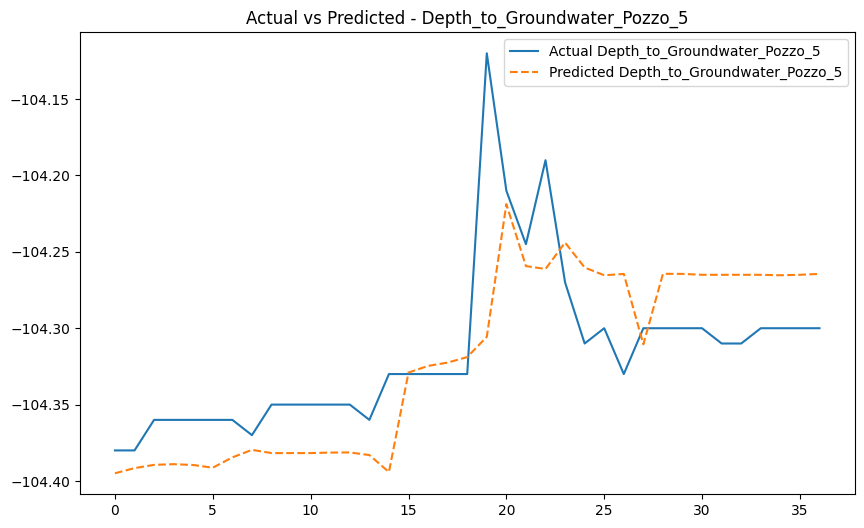

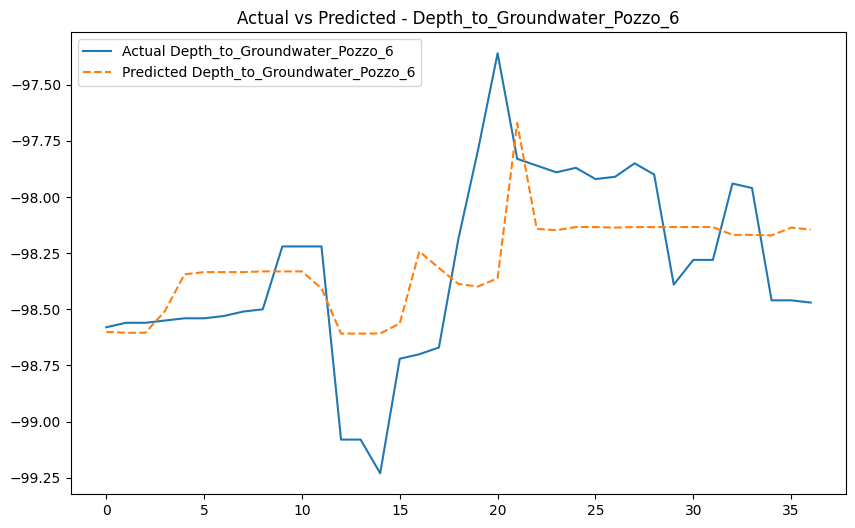

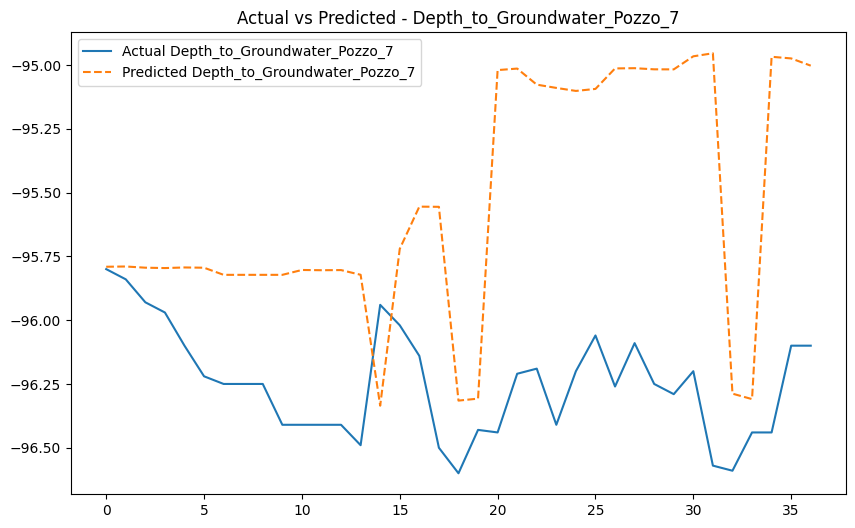

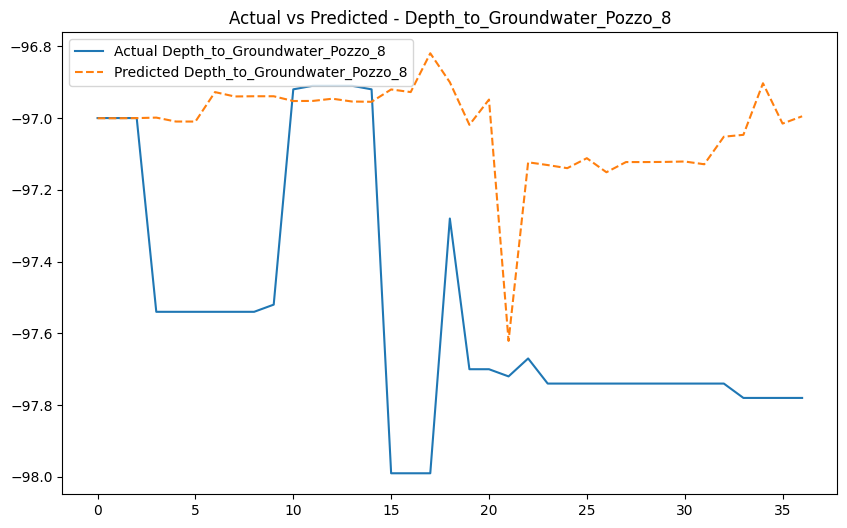

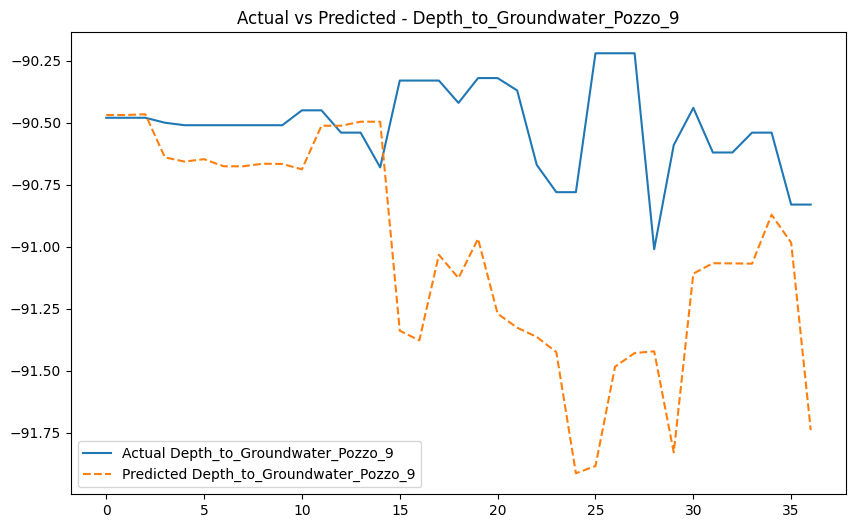

In [7]:
plot_actual_vs_predicted()

Model Optimization

In [8]:
xgb_model = xgb.XGBRegressor()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],         # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size shrinkage
    'max_depth': [3, 5],                 # Maximum depth of a tree
    'subsample': [0.7, 1.0],           # Fraction of samples used for training each tree
    'colsample_bytree': [0.7, 1.0]     # Fraction of features used per tree
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    verbose=1,  # Set to 1 for output during the search
    n_jobs=-1   # Use all available cores
)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and model from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [9]:
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error of best model: {mse}')

Mean Squared Error of best model: 5.3511151200034766


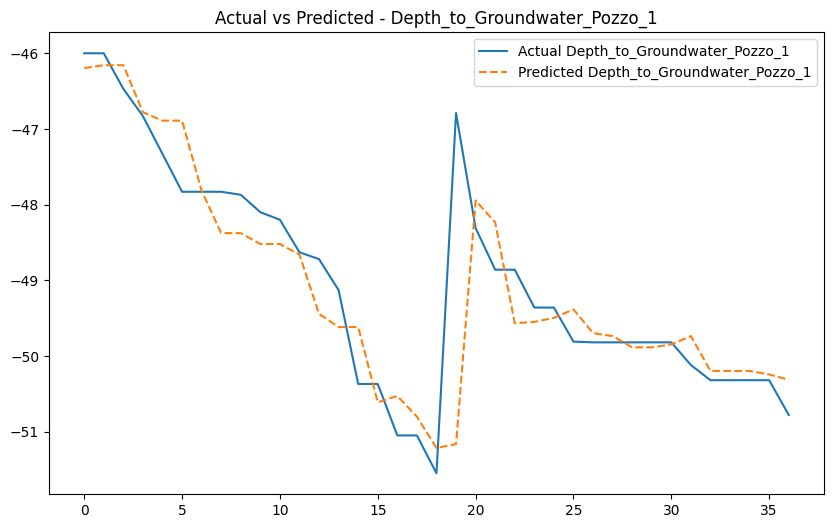

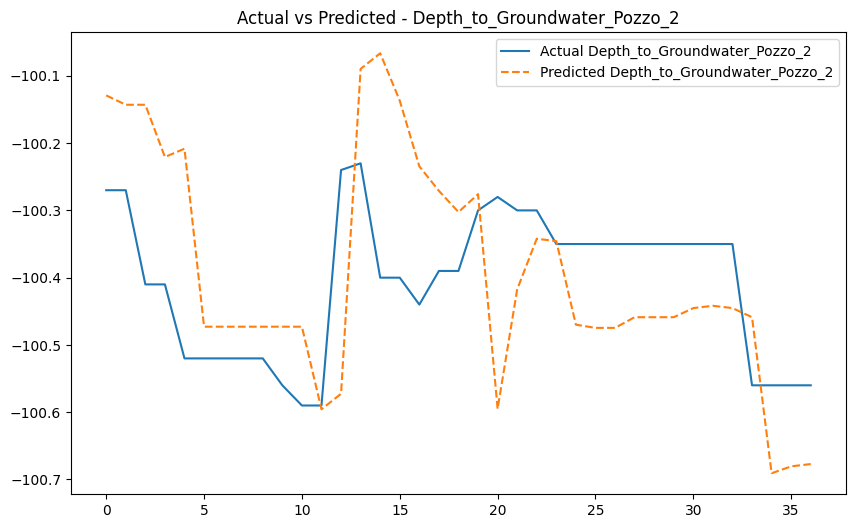

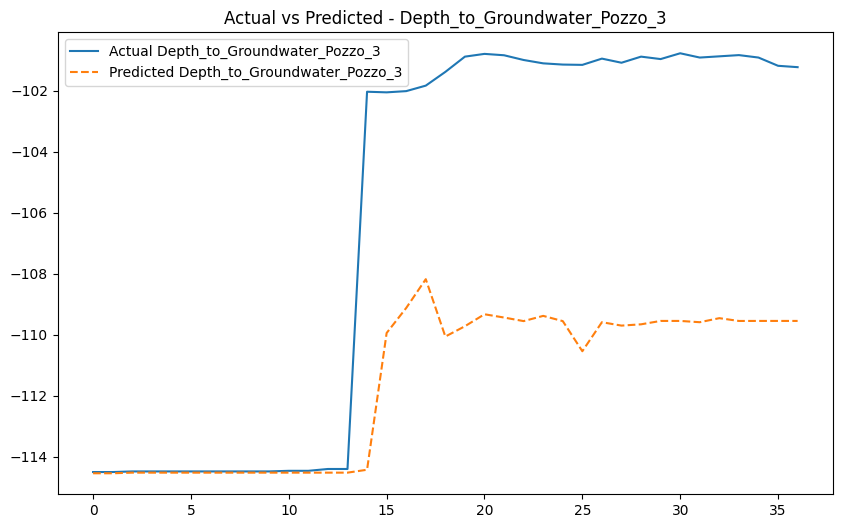

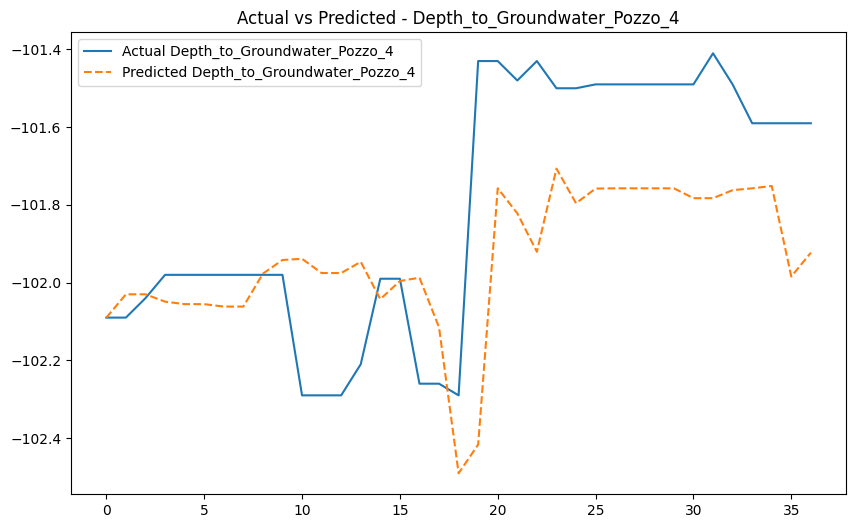

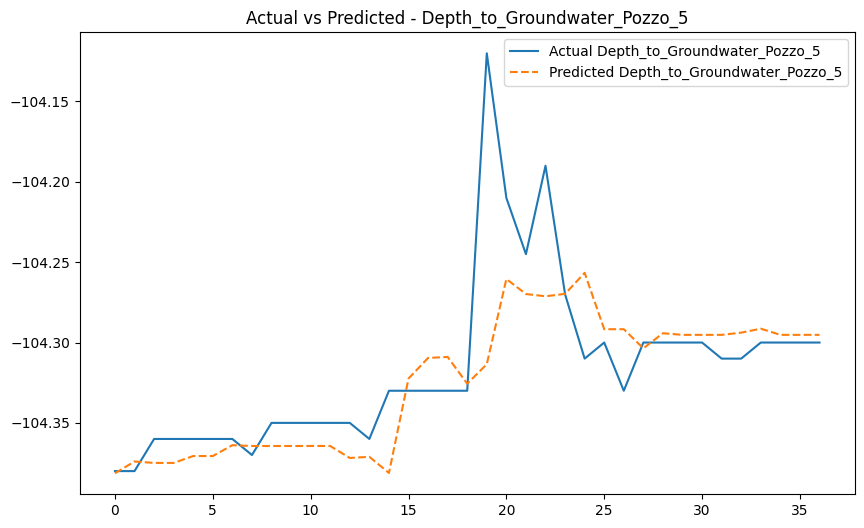

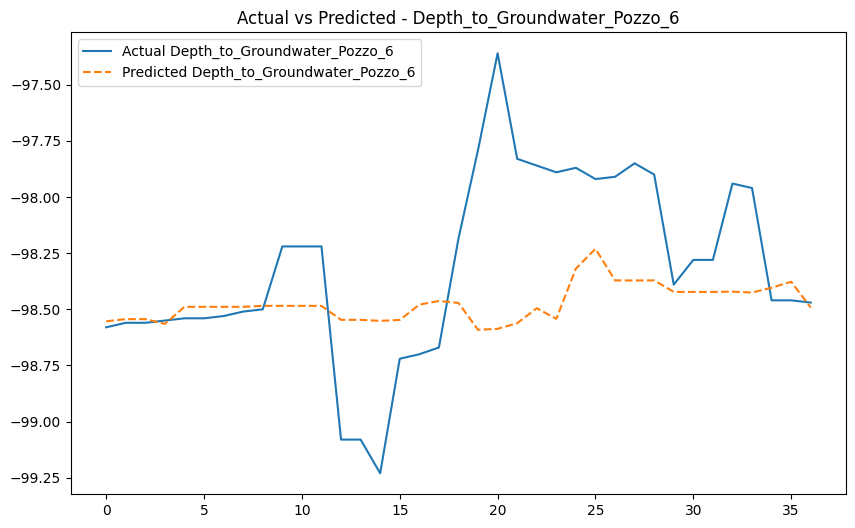

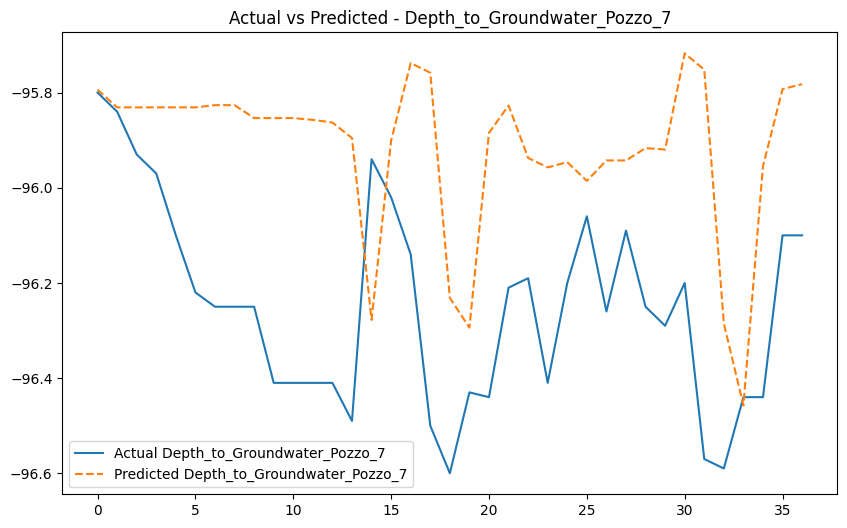

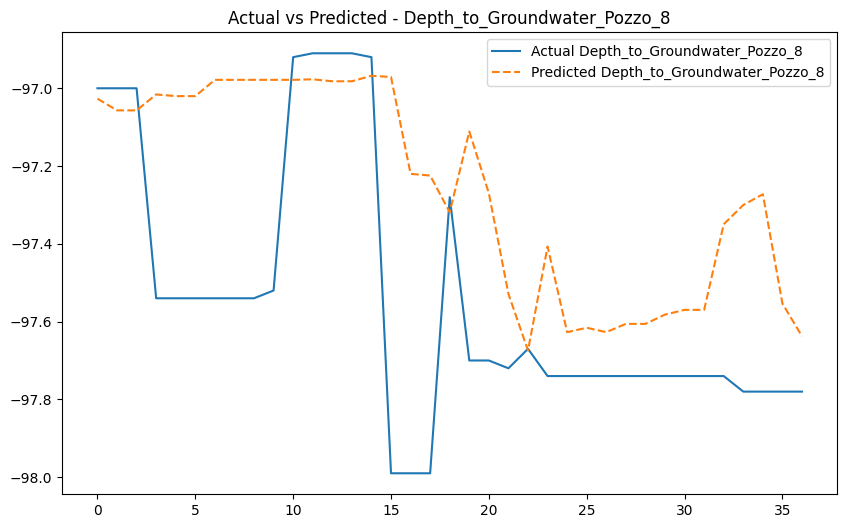

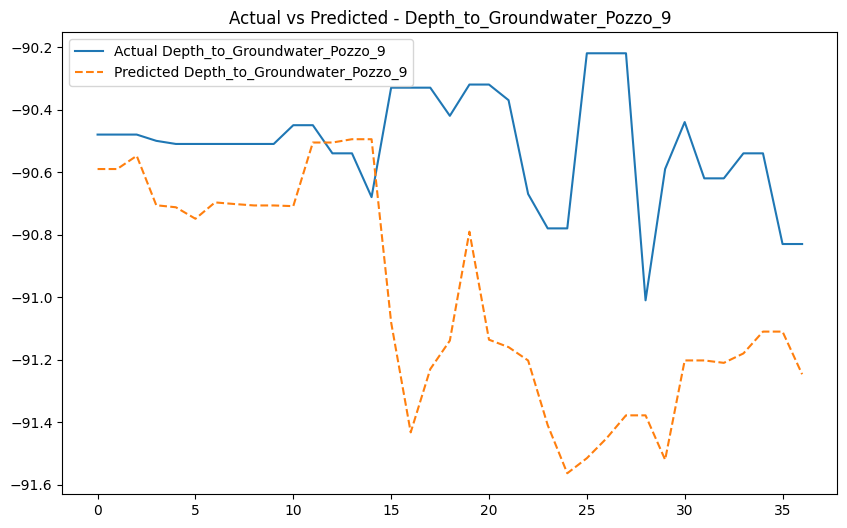

In [10]:
plot_actual_vs_predicted()

In [11]:
import pickle

# Save the model to a file using pickle
with open('../supervised/xgboost_model_Aquifer_Doganella.pkl', 'wb') as file:
    pickle.dump(best_model, file)